In [4]:
#Predict the win probability of team 'SRH' at the end of each over in the finals of IPL 2016 
#with the training data as all other matches played in 2016 season

In [7]:
#Load modules
import operator
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import seaborn as sns
%matplotlib inline

pd.set_option('display.max_columns', 50)

In [8]:
#Read Dataset
data_path = "/Users/prabhunathan/Documents/_DevWorkspace/_Python_Anaconda/IPL_Prediction_Kaggle/Dataset/"
match_df = pd.read_csv(data_path+"matches.csv")
score_df = pd.read_csv(data_path+"deliveries.csv")
match_df.head()

,id,season,city,date,team1,team2,toss_winner,toss_decision,result,dl_applied,winner,win_by_runs,win_by_wickets,player_of_match,venue,umpire1,umpire2,umpire3
0,1,2008,Bangalore,2008-04-18,Kolkata Knight Riders,Royal Challengers Bangalore,Royal Challengers Bangalore,field,normal,0,Kolkata Knight Riders,140,0,BB McCullum,M Chinnaswamy Stadium,Asad Rauf,RE Koertzen,NaN
1,2,2008,Chandigarh,2008-04-19,Chennai Super Kings,Kings XI Punjab,Chennai Super Kings,bat,normal,0,Chennai Super Kings,33,0,MEK Hussey,"Punjab Cricket Association Stadium, Mohali",MR Benson,SL Shastri,NaN
2,3,2008,Delhi,2008-04-19,Rajasthan Royals,Delhi Daredevils,Rajasthan Royals,bat,normal,0,Delhi Daredevils,0,9,MF Maharoof,Feroz Shah Kotla,Aleem Dar,GA Pratapkumar,NaN
3,4,2008,Mumbai,2008-04-20,Mumbai Indians,Royal Challengers Bangalore,Mumbai Indians,bat,normal,0,Royal Challengers Bangalore,0,5,MV Boucher,Wankhede Stadium,SJ Davis,DJ Harper,NaN
4,5,2008,Kolkata,2008-04-20,Deccan Chargers,Kolkata Knight Riders,Deccan Chargers,bat,normal,0,Kolkata Knight Riders,0,5,DJ Hussey,Eden Gardens,BF Bowden,K Hariharan,NaN


In [9]:
#Matches played only in 2016 season are considered for this analysis
match_df = match_df.ix[match_df.season==2016,:]
match_df = match_df.ix[match_df.dl_applied == 0,:]
match_df.head()

,id,season,city,date,team1,team2,toss_winner,toss_decision,result,dl_applied,winner,win_by_runs,win_by_wickets,player_of_match,venue,umpire1,umpire2,umpire3
517,518,2016,Mumbai,2016-04-09,Mumbai Indians,Rising Pune Supergiants,Mumbai Indians,bat,normal,0,Rising Pune Supergiants,0,9,AM Rahane,Wankhede Stadium,HDPK Dharmasena,CK Nandan,NaN
518,519,2016,Kolkata,2016-04-10,Delhi Daredevils,Kolkata Knight Riders,Kolkata Knight Riders,field,normal,0,Kolkata Knight Riders,0,9,AD Russell,Eden Gardens,S Ravi,C Shamshuddin,NaN
519,520,2016,Chandigarh,2016-04-11,Kings XI Punjab,Gujarat Lions,Gujarat Lions,field,normal,0,Gujarat Lions,0,5,AJ Finch,"Punjab Cricket Association IS Bindra Stadium, ...",AK Chaudhary,VA Kulkarni,NaN
520,521,2016,Bangalore,2016-04-12,Royal Challengers Bangalore,Sunrisers Hyderabad,Sunrisers Hyderabad,field,normal,0,Royal Challengers Bangalore,45,0,AB de Villiers,M Chinnaswamy Stadium,HDPK Dharmasena,VK Sharma,NaN
521,522,2016,Kolkata,2016-04-13,Kolkata Knight Riders,Mumbai Indians,Mumbai Indians,field,normal,0,Mumbai Indians,0,6,RG Sharma,Eden Gardens,Nitin Menon,S Ravi,NaN


In [ ]:
# Preprocessing is over. Now create variables necessary for building model.
# Some of them are 'Runs scored in the last over', 'Wickets taken in the last over', 'Total score of the innings',
# 'Total wickets', 'Target that the team is chasing down', 'Remaining target', 'Run rate', 'Required run rate', 
# 'Difference between run rate and required run rate', 'Binary variables on whether the team for which we are 
#  predicting is batting team or bowling team'. Others variables include 'Team name', 'Opponent team name', 'Score in the last 'n' overs', 
# 'Players who are batting', 'Player who is bowling' and so on.

In [10]:
# Runs and wickets per over
score_df = pd.merge(score_df, match_df[['id','season', 'winner', 'result', 'dl_applied', 'team1', 'team2']], left_on='match_id', right_on='id')
score_df.player_dismissed.fillna(0, inplace=True)
score_df['player_dismissed'].ix[score_df['player_dismissed'] != 0] = 1
train_df = score_df.groupby(['match_id', 'inning', 'over', 'team1', 'team2', 'batting_team', 'winner'])[['total_runs', 'player_dismissed']].agg(['sum']).reset_index()
train_df.columns = train_df.columns.get_level_values(0)

# Innings score and wickets
train_df['innings_wickets'] = train_df.groupby(['match_id', 'inning'])['player_dismissed'].cumsum()
train_df['innings_score'] = train_df.groupby(['match_id', 'inning'])['total_runs'].cumsum()
train_df.head()

# Get the target column 
temp_df = train_df.groupby(['match_id', 'inning'])['total_runs'].sum().reset_index()
temp_df = temp_df.ix[temp_df['inning']==1,:]
temp_df['inning'] = 2
temp_df.columns = ['match_id', 'inning', 'score_target']
train_df = train_df.merge(temp_df, how='left', on = ['match_id', 'inning'])
train_df['score_target'].fillna(-1, inplace=True)

# Get the remaining target
def get_remaining_target(row):
    if row['score_target'] == -1.:
        return -1
    else:
        return row['score_target'] - row['innings_score']

train_df['remaining_target'] = train_df.apply(lambda row: get_remaining_target(row),axis=1)

# Get the run rate
train_df['run_rate'] = train_df['innings_score'] / train_df['over']

# Get the remaining run rate
def get_required_rr(row):
    if row['remaining_target'] == -1:
        return -1.
    elif row['over'] == 20:
        return 99
    else:
        return row['remaining_target'] / (20-row['over'])
    
train_df['required_run_rate'] = train_df.apply(lambda row: get_required_rr(row), axis=1)

def get_rr_diff(row):
    if row['inning'] == 1:
        return -1
    else:
        return row['run_rate'] - row['required_run_rate']
    
train_df['runrate_diff'] = train_df.apply(lambda row: get_rr_diff(row), axis=1)
train_df['is_batting_team'] = (train_df['team1'] == train_df['batting_team']).astype('int')
train_df['target'] = (train_df['team1'] == train_df['winner']).astype('int')

train_df.head()

/Users/prabhunathan/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,match_id,inning,over,team1,team2,batting_team,winner,total_runs,player_dismissed,innings_wickets,innings_score,score_target,remaining_target,run_rate,required_run_rate,runrate_diff,is_batting_team,target
0,518,1,1,Mumbai Indians,Rising Pune Supergiants,Mumbai Indians,Rising Pune Supergiants,8,0,0,8,-1.0,-1.0,8.000000,-1.0,-1.0,1,0
1,518,1,2,Mumbai Indians,Rising Pune Supergiants,Mumbai Indians,Rising Pune Supergiants,4,1,1,12,-1.0,-1.0,6.000000,-1.0,-1.0,1,0
2,518,1,3,Mumbai Indians,Rising Pune Supergiants,Mumbai Indians,Rising Pune Supergiants,8,0,1,20,-1.0,-1.0,6.666667,-1.0,-1.0,1,0
3,518,1,4,Mumbai Indians,Rising Pune Supergiants,Mumbai Indians,Rising Pune Supergiants,9,1,2,29,-1.0,-1.0,7.250000,-1.0,-1.0,1,0
4,518,1,5,Mumbai Indians,Rising Pune Supergiants,Mumbai Indians,Rising Pune Supergiants,1,2,4,30,-1.0,-1.0,6.000000,-1.0,-1.0,1,0


In [11]:
# Split Data and use final match data for validation sample
x_cols = ['inning', 'over', 'total_runs', 'player_dismissed', 'innings_wickets', 'innings_score', 'score_target', 'remaining_target', 'run_rate', 'required_run_rate', 'runrate_diff', 'is_batting_team']

# let us take all the matches but for the final as development sample and final as val sample #
val_df = train_df.ix[train_df.match_id == 577,:]
dev_df = train_df.ix[train_df.match_id != 577,:]

# create the input and target variables #
dev_X = np.array(dev_df[x_cols[:]])
dev_y = np.array(dev_df['target'])
val_X = np.array(val_df[x_cols[:]])[:-1,:]
val_y = np.array(val_df['target'])[:-1]
print(dev_X.shape, dev_y.shape)
print(val_X.shape, val_y.shape)

((2135, 12), (2135,))
((39, 12), (39,))


In [12]:
# Using XGBoost for odeling
# http://dmlc.cs.washington.edu/xgboost.html
def runXGB(train_X, train_y, seed_val=0):
    param = {}
    param['objective'] = 'binary:logistic'
    param['eta'] = 0.05
    param['max_depth'] = 8
    param['silent'] = 1
    param['eval_metric'] = "auc"
    param['min_child_weight'] = 1
    param['subsample'] = 0.7
    param['colsample_bytree'] = 0.7
    param['seed'] = seed_val
    num_rounds = 100

    plst = list(param.items())
    xgtrain = xgb.DMatrix(train_X, label=train_y)
    model = xgb.train(plst, xgtrain, num_rounds)
    return model

In [13]:
# Build model and get prection for final match
model = runXGB(dev_X, dev_y)
xgtest = xgb.DMatrix(val_X)
preds = model.predict(xgtest)

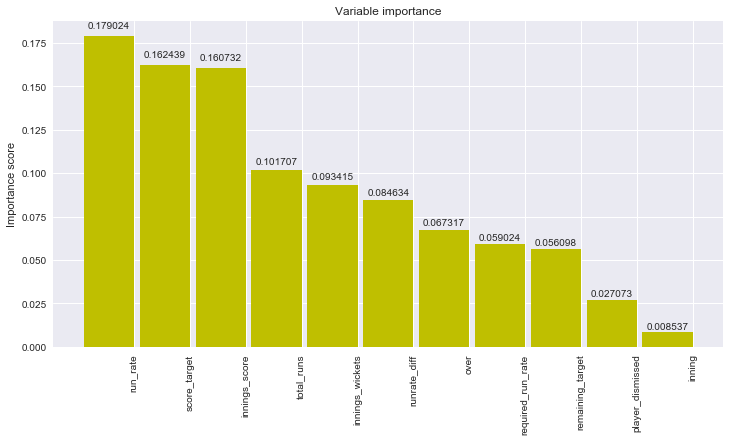

In [14]:
# Important variables contributing to win
def create_feature_map(features):
    outfile = open('xgb.fmap', 'w')
    for i, feat in enumerate(features):
        outfile.write('{0}\t{1}\tq\n'.format(i,feat))
    outfile.close()

create_feature_map(x_cols)
importance = model.get_fscore(fmap='xgb.fmap')
importance = sorted(importance.items(), key=operator.itemgetter(1), reverse=True)
imp_df = pd.DataFrame(importance, columns=['feature','fscore'])
imp_df['fscore'] = imp_df['fscore'] / imp_df['fscore'].sum()

# create a function for labeling #
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.02*height,
                '%f' % float(height),
                ha='center', va='bottom')
        
labels = np.array(imp_df.feature.values)
ind = np.arange(len(labels))
width = 0.9
fig, ax = plt.subplots(figsize=(12,6))
rects = ax.bar(ind, np.array(imp_df.fscore.values), width=width, color='y')
ax.set_xticks(ind+((width)/2.))
ax.set_xticklabels(labels, rotation='vertical')
ax.set_ylabel("Importance score")
ax.set_title("Variable importance")
autolabel(rects)
plt.show()

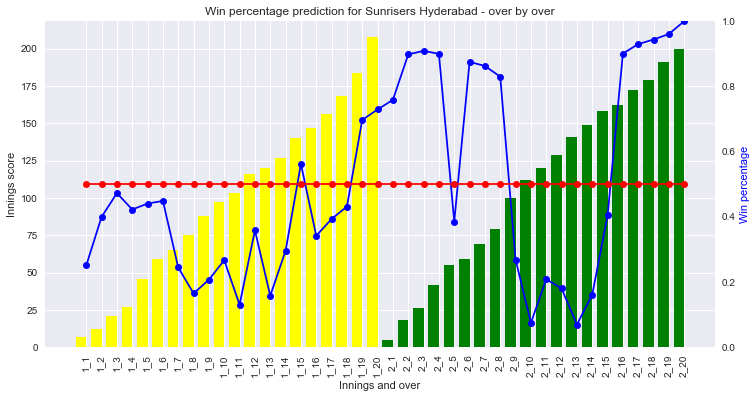

In [15]:
# Win probability at end of each over
out_df = pd.DataFrame({'Team1':val_df.team1.values})
out_df['is_batting_team'] = val_df.is_batting_team.values
out_df['innings_over'] = np.array(val_df.apply(lambda row: str(row['inning']) + "_" + str(row['over']), axis=1))
out_df['innings_score'] = val_df.innings_score.values
out_df['innings_wickets'] = val_df.innings_wickets.values
out_df['score_target'] = val_df.score_target.values
out_df['total_runs'] = val_df.total_runs.values
out_df['predictions'] = list(preds)+[1]

fig, ax1 = plt.subplots(figsize=(12,6))
ax2 = ax1.twinx()
labels = np.array(out_df['innings_over'])
ind = np.arange(len(labels))
width = 0.7
rects = ax1.bar(ind, np.array(out_df['innings_score']), width=width, color=['yellow']*20 + ['green']*20)
ax1.set_xticks(ind+((width)/2.))
ax1.set_xticklabels(labels, rotation='vertical')
ax1.set_ylabel("Innings score")
ax1.set_xlabel("Innings and over")
ax1.set_title("Win percentage prediction for Sunrisers Hyderabad - over by over")

ax2.plot(ind+0.35, np.array(out_df['predictions']), color='b', marker='o')
ax2.plot(ind+0.35, np.array([0.5]*40), color='red', marker='o')
ax2.set_ylabel("Win percentage", color='b')
ax2.set_ylim([0,1])
ax2.grid(b=False)
plt.show()

In [16]:
#Observations
# Scores in the corresponding over: Yellow bar - SRH ; Green - RCB
# Red line - Equal win probability; Blue line - Win probability of SRH at the end of each over.


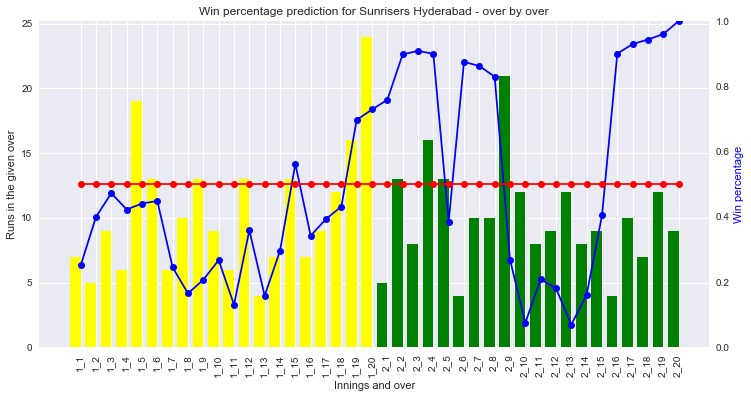

In [17]:
# No of runs scored in the over instead of cumulative runs (like previous viz)
fig, ax1 = plt.subplots(figsize=(12,6))
ax2 = ax1.twinx()
labels = np.array(out_df['innings_over'])
ind = np.arange(len(labels))
width = 0.7
rects = ax1.bar(ind, np.array(out_df['total_runs']), width=width, color=['yellow']*20 + ['green']*20)
ax1.set_xticks(ind+((width)/2.))
ax1.set_xticklabels(labels, rotation='vertical')
ax1.set_ylabel("Runs in the given over")
ax1.set_xlabel("Innings and over")
ax1.set_title("Win percentage prediction for Sunrisers Hyderabad - over by over")

ax2.plot(ind+0.35, np.array(out_df['predictions']), color='b', marker='o')
ax2.plot(ind+0.35, np.array([0.5]*40), color='red', marker='o')
ax2.set_ylabel("Win percentage", color='b')
ax2.set_ylim([0,1])
ax2.grid(b=False)
plt.show()

In [18]:
# OBSERVATIONS
#  SRH scored 16 and 24 runs in the last 2 overs whch gave them an edge over RCB in the final. They have constant
#  low run rate in the first 8 overs, so the probability of SRH winning the match was above 0.5. After 8th over (when
#  RCB scored 21 runs, the winning probability reduced). Wickets fell in 13th and 15th over and SRH conceded only 
#  4 runs in 16th over, which shifted the game towards SRH and increased the probability of winning the match.